In [4]:
import yaml

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from scipy.stats import probplot

import sys
sys.path.append("../")

from electronfactors.model.utilities import create_model, pull_data, fit_give, estimate_population_uncertainty
from electronfactors.visuals.utilities import create_green_cm

In [5]:
from matplotlib import rc
rc('font',**{'family':'serif',
             'size':'16'})
rc('text', usetex=True)

rc('legend', fontsize=16)

In [6]:
with open("model_cache/12MeV_10app_100ssd.yml", 'r') as file:
    cutout_data = yaml.load(file)
    
label = np.array([key for key in cutout_data])
book_factor = np.array([item[0] == 'P' for i, item in enumerate(label)])

custom_label = label[~book_factor]

width = np.array([cutout_data[key]['width'] for key in custom_label])
length = np.array([cutout_data[key]['length'] for key in custom_label])
factor = np.array([cutout_data[key]['factor'] for key in custom_label])

perimeter = np.pi / 2 * (3*(width + length) - np.sqrt((3*width + length)*(3*length + width)))
area = np.pi / 4 * width * length
eqPonA = perimeter / area

In [7]:
def create_histogram(data):
    plt.figure(figsize=(6 * 1.618, 6))
    
    bins = np.arange(-1.5, 2, 0.5)
    dbins = bins[1] - bins[0]
    binsTrans = bins - dbins/2

    binsTrans = binsTrans.reshape(-1,1)
    binNum = np.argmin(abs(binsTrans - data),0)

    representative_height = np.zeros(len(binNum))

    for i in range(len(bins)):
        binRef = (binNum == i)
        representative_height[binRef] = np.arange(sum(binRef)) + 1

    plt.hist(data, bins, alpha=0.6, lw=2)
    plt.scatter(data, representative_height, zorder=2, s=120, alpha=0.8, lw=1.5)
    
    uncertainty = estimate_population_uncertainty(data)
    
    print("Mean = %0.2f" % (np.mean(data)))
    print("Uncertainty = %0.2f" % (uncertainty))

In [8]:
def display_fit(width, eqPonA, factor, model):
    plt.figure(figsize=(6 * 1.618, 6))
    x = np.arange(np.floor(np.min(width)) - 0.5, np.ceil(np.max(width)) + 0.5, 0.05)
    y = np.arange(np.floor(np.min(eqPonA)*10)/10 - 0.2, np.ceil(np.max(eqPonA)*10)/10 + 0.2, 0.005)

    xx, yy = np.meshgrid(x, y)

    zz = model(xx, yy)
    give = fit_give(xx, yy, width, eqPonA, factor, kx=2, ky=1)

    outOfTolerance = (give > 0.5)

    zz[outOfTolerance] = np.nan

    c = plt.contourf(xx, yy, zz, 100, alpha=1)
    plt.colorbar(c)

    plt.contour(xx, yy, give, levels=[0.5], colors='g')

    plt.scatter(width, eqPonA, s=45, alpha=0.9, zorder=3)

    plt.xlabel(r'Width (cm)')
    plt.ylabel(r'Perimeter / Area (cm$^{-1}$)')
    plt.title(r'Bivariate spline fit')

In [377]:
def outlier_detection(amount=13, n=100, outlier_boundary=2.5):
    
    correct = 0
    false_positive = 0
    not_found = 0
    
    for i in range(n):
        order = np.arange(len(width))
        np.random.shuffle(order)
        reference = order[0:amount]
        check = np.setdiff1d(np.arange(len(width)), reference)
        give = np.zeros(len(check))
        predictions = np.zeros(len(check))

        index_of_shift = int(np.floor(np.random.uniform(0,amount)))
        shifted_factor = factor[reference]
        shift = np.floor(np.random.uniform(0,2)) * 0.04 - 0.02
        shifted_factor[index_of_shift] = shifted_factor[index_of_shift] + shift

        model = create_model(width[reference], eqPonA[reference], shifted_factor)
        predictions = model(width[reference], eqPonA[reference])

        residuals = predictions - shifted_factor

        outlier_test = np.abs(residuals) > np.std(residuals) * outlier_boundary
        if np.sum(outlier_test)>0:
            if np.where(outlier_test)[0][0] == index_of_shift:
                correct += 1
            else:
                false_positive += 1
        else:
            not_found += 1
                
    return correct, false_positive, not_found

array([ 0.02,  0.02])

In [392]:
amount_range = np.arange(8, 40)
n = 10000
outlier_boundary = 2.5

correct = np.zeros(len(amount_range))
false_positive = np.zeros(len(amount_range))
not_found = np.zeros(len(amount_range))

for i, amount in enumerate(amount_range):   
    (
        correct[i], false_positive[i], not_found[i]
    ) = outlier_detection(amount=amount, n=n, outlier_boundary=outlier_boundary)

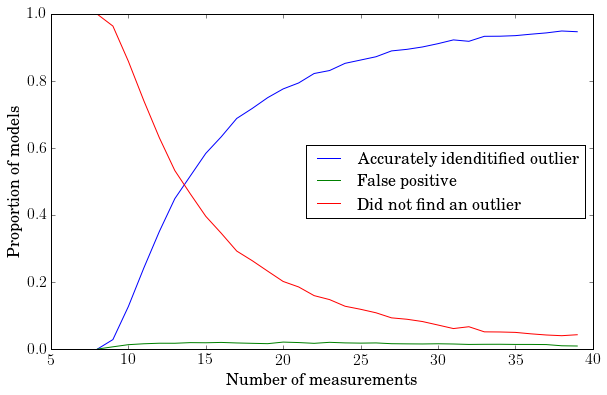

In [399]:
plt.figure(figsize=(6 * 1.618, 6))

plt.plot(amount_range, correct/n, label=r'Accurately idenditified outlier')
plt.plot(amount_range, false_positive/n, label=r'False positive')
plt.plot(amount_range, not_found/n, label=r'Did not find an outlier')

plt.xlabel(r'Number of measurements')
plt.ylabel(r'Proportion of models')

plt.legend(loc='center right')